## Notebook for load and processing molecules  using rdkit

In this notebook we proceed to load the molecules (actives and decoys) from CSAR, DUD and DEKOIS2.0 datasets. Molecules are read from sdf files previously created.

In [3]:
import pandas as pd
import numpy as np
from glob import glob
import os, pickle

from rdkit import Chem
from rdkit.Chem import AllChem

In [4]:
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')

### Useful functions 

In [5]:
from analyse_db_molecules import load_molecules_from_dir, get_files_list, get_mol_dataframe

## Cocristalized ligands
### Read the cocrystalized ligands
Previously, in notebook `1_Working_with_3D_structures_in_rdkit` we have saved a python object containing a dataframe with the cocristalized ligands. That dataframe is the following:

In [6]:
path_to_file_cocrys = os.path.join(*F'../data/rdkit_molecules/cdk2_365_cocristalized_ligands.pyobj'.split('/'))
with open(path_to_file_cocrys, 'rb') as f:
    df_crys_poses_rdk = pickle.load(f)
df_crys_poses_rdk.head()

,Lig,mol_rdk,file,Labels_conf,Validation
1aq1,STU,<rdkit.Chem.rdchem.Mol object at 0x7fe752947cb0>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_b,v1
1b38,ATP,<rdkit.Chem.rdchem.Mol object at 0x7fe752947cf0>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1b39,ATP,<rdkit.Chem.rdchem.Mol object at 0x7fe752947d30>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1ckp,PVB,<rdkit.Chem.rdchem.Mol object at 0x7fe752947d70>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1di8,DTQ,<rdkit.Chem.rdchem.Mol object at 0x7fe752947db0>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1


From this dataframe we are only interested in the ligand name, and in the `mol_rd` columns, which has the *rdkit* molecule instances. We also need to add column indicating that the molecule is an **Active**, or Inactive, ligand. Of course, because these molecules were cocristalized with the protein we're going to assume all of them are actives.  

Also, we are going to remove duplicate ligands, mainly because for this analysis we are not interested in the 3D conformation. **At the end we only going to keep 315 ligands from the original 365**.

In [7]:
df_COCRYS = df_crys_poses_rdk.reset_index()[['Lig', 'mol_rdk']]
df_COCRYS.drop_duplicates(subset = 'Lig', inplace = True)
df_COCRYS.set_index('Lig', inplace = True)
df_COCRYS['Activity'] = 'active'
df_COCRYS['sanitized'] = True
df_COCRYS = df_COCRYS[['Activity', 'mol_rdk', 'sanitized']]
df_COCRYS.shape

(315, 3)

In [8]:
df_COCRYS.head()

,Activity,mol_rdk,sanitized
Lig,,,
STU,active,<rdkit.Chem.rdchem.Mol object at 0x7fe752947cb0>,True
ATP,active,<rdkit.Chem.rdchem.Mol object at 0x7fe752947cf0>,True
PVB,active,<rdkit.Chem.rdchem.Mol object at 0x7fe752947d70>,True
DTQ,active,<rdkit.Chem.rdchem.Mol object at 0x7fe752947db0>,True
HMD,active,<rdkit.Chem.rdchem.Mol object at 0x7fe752947df0>,True


## CSAR dataset
### Read the CSAR dataset molecules

In [20]:
# File of the python object
csar_obj_file = os.path.join(*F'../data/rdkit_molecules/cdk2_CSAR_ligands.pyobj'.split('/'))

if os.path.isfile(csar_obj_file):
    with open(csar_obj_file, 'rb') as f:
        df_CSAR = pickle.load(f)

else:
    # Firs we got the molecules dictionary
    path_to_file_csar_sdfs = \
    os.path.join(*F'../../ARCHIVOS/CRISTALES/LIGS_CDK2/CSAR/sdf/*'.split('/'))
    csar_file_list = glob(path_to_file_csar_sdfs)
    # sort alphanumericalñy
    csar_file_list.sort(key = lambda x: int(x.split('/')[-1].split('.')[0].replace('CS', '')))

    # Load the molecules using the function previously declared
    csar_molecules_dic = load_molecules_from_dir(csar_file_list)
    # Convert to a dataframe
    df_CSAR = pd.DataFrame(csar_molecules_dic).T
    df_CSAR.columns = ['mol_rdk', 'sanitized']
    # The information about if the molecule is active or inactive is in the following file
    df_csar_activity = pd.read_json('../data/csar_Binding_Data_Corrected_2016.json')
    # merge both dataframes
    df_CSAR['Activity'] = df_csar_activity['ActiveInactive'].str.lower()
    # Naming the columns
    df_CSAR = df_CSAR[['Activity', 'mol_rdk', 'sanitized']]
    
    # Save the file
    with open(csar_obj_file, 'wb') as f:
        pickle.dump(df_CSAR, f)

print(df_CSAR.shape)

(111, 3)


In [10]:
df_CSAR.head()

,Activity,mol_rdk,sanitized
CS1,active,<rdkit.Chem.rdchem.Mol object at 0x7fe752947c70>,True
CS2,active,<rdkit.Chem.rdchem.Mol object at 0x7fe752853630>,True
CS3,active,<rdkit.Chem.rdchem.Mol object at 0x7fe752853670>,True
CS4,active,<rdkit.Chem.rdchem.Mol object at 0x7fe7528536b0>,True
CS5,inactive,<rdkit.Chem.rdchem.Mol object at 0x7fe7528536f0>,True


## DUD 2006 Dataset

In [18]:
dud_obj_file = os.path.join(*F'../data/rdkit_molecules/cdk2_DUD_ligands.pyobj'.split('/'))

if os.path.isfile(dud_obj_file):
    with open(dud_obj_file, 'rb') as f:
        df_DUD = pickle.load(f)

else:
    # Firs we got the molecules dictionary
    path_to_file_dud_sdfs = \
    os.path.join(*F'../../ARCHIVOS/CRISTALES/LIGS_CDK2/DUDE_DECOYS/DUD_2006/sdf/'.split('/'))
    # Get the files list
    dud_file_list = get_files_list(path_to_sdfs = path_to_file_dud_sdfs, 
                                   actives_name='ligand', inactives_name='decoy')

    # Load the molecules using the function previously declared
    # load_molecules_from_dir(path_to_file_csar_sdfs)
    dud_molecules_dic = load_molecules_from_dir(dud_file_list)

    # Convert to a dataframe
    df_DUD = get_mol_dataframe(mol_dictionary=dud_molecules_dic)
    
    with open(dud_obj_file, 'wb') as f:
        pickle.dump(df_DUD, f)
        
print(df_DUD.shape)

(2146, 3)


In [12]:
df_DUD.head()

,Activity,mol_rdk,sanitized
ligand_1,active,<rdkit.Chem.rdchem.Mol object at 0x7fe7528535f0>,True
ligand_2,active,<rdkit.Chem.rdchem.Mol object at 0x7fe752878430>,True
ligand_3,active,<rdkit.Chem.rdchem.Mol object at 0x7fe752878470>,True
ligand_4,active,<rdkit.Chem.rdchem.Mol object at 0x7fe7528784b0>,True
ligand_5,active,<rdkit.Chem.rdchem.Mol object at 0x7fe7528784f0>,True


## DEKOIS Dataset

In [21]:
dekois_obj_file = os.path.join(*F'../data/rdkit_molecules/cdk2_DEKOIS_ligands.pyobj'.split('/'))

if os.path.isfile(dekois_obj_file):
    with open(dekois_obj_file, 'rb') as f:
        df_DEKOIS = pickle.load(f)

else:
    # Firs we got the molecules dictionary
    path_to_file_dekois_sdfs = \
    os.path.join(*F'../../ARCHIVOS/CRISTALES/LIGS_CDK2/DEKOIS_2/sdf/'.split('/'))
    # Get the files list
    dekois_file_list = get_files_list(path_to_sdfs = path_to_file_dekois_sdfs, 
                                   actives_name='ligand', inactives_name='decoy')

    # Load the molecules using the function previously declared
    # load_molecules_from_dir(path_to_file_csar_sdfs)
    dekois_molecules_dic = load_molecules_from_dir(dekois_file_list)

    # Convert to a dataframe
    df_DEKOIS = get_mol_dataframe(mol_dictionary=dekois_molecules_dic)
    
    with open(dekois_obj_file, 'wb') as f:
        pickle.dump(df_DEKOIS, f)
        
print(df_DEKOIS.shape)

(1240, 3)


In [14]:
df_DEKOIS.head()

,Activity,mol_rdk,sanitized
ligand_1,active,<rdkit.Chem.rdchem.Mol object at 0x7fe7528783f0>,True
ligand_2,active,<rdkit.Chem.rdchem.Mol object at 0x7fe7527dadf0>,True
ligand_3,active,<rdkit.Chem.rdchem.Mol object at 0x7fe7527dae30>,True
ligand_4,active,<rdkit.Chem.rdchem.Mol object at 0x7fe7527dae70>,True
ligand_5,active,<rdkit.Chem.rdchem.Mol object at 0x7fe7527daeb0>,True


## Dictionary of Datasets

In [15]:
lig_datasets = {'COCRYS': df_COCRYS, 'CSAR': df_CSAR, 'DUD': df_DUD, 'DEKOIS': df_DEKOIS}

### Save the python dictionary using pickle

In [30]:
import pickle

file_rd_mols = './rdKit_db_molecules.obj'
if os.path.isfile(file_rd_mols):
    with open(file_rd_mols, 'rb') as f:
        lig_datasets = pickle.load(f)
else:
    with open(file_rd_mols, 'wb') as f:
        pickle.dump(lig_datasets, f)

## Molecular Weight and Num. Heavy Atoms

In [16]:
from rdkit.Chem import Descriptors, Lipinski

In [17]:
# Get the molecular weight and # of heavy atoms for each ligand

for dataset in lig_datasets.values():
    # molecular weight
    dataset['MW'] = [round(Descriptors.MolWt(m), 3) for m in dataset['mol_rdk']]
    # number of heavy atoms
    dataset['num_atoms'] = [round(Chem.Lipinski.HeavyAtomCount(m), 3) for m in dataset['mol_rdk']]

## Calculate the Fingerprints

In [16]:
for dataset in lig_datasets.values():
    # molecular weight
    dataset['fps'] = [Chem.RDKFingerprint(i) for i in dataset['mol_rdk']]

## Histograms 
### Molecular Weight and Num. of Atoms

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_context("talk")

### All molecules in all libraries

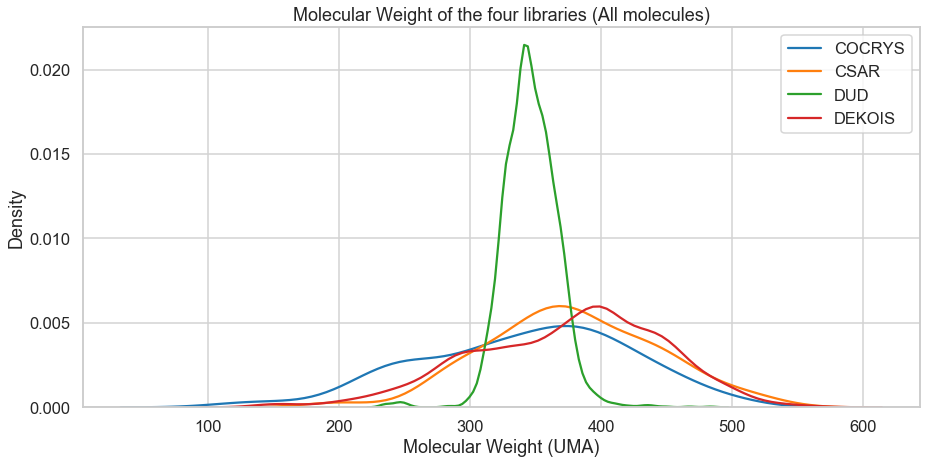

In [18]:
plt.figure(figsize=(15,7))
for name, dataset in lig_datasets.items():
    sns.distplot(dataset['MW'], label = name, hist = False, bins = 30, norm_hist = False )
plt.xlabel('Molecular Weight (UMA)')
plt.ylabel('Density')
plt.title('Molecular Weight of the four libraries (All molecules)')
plt.grid(c='lightgrey')

### Only active molecules

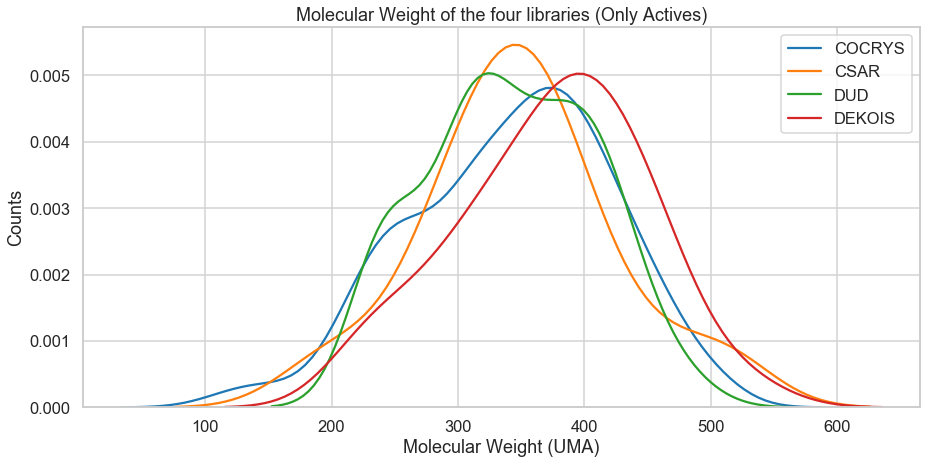

In [19]:
plt.figure(figsize=(15,7))
for name, dataset in lig_datasets.items():
    df = dataset[dataset['Activity'] == 'active']
    sns.distplot(df['MW'], label = name, hist = False, bins = 50)
plt.xlabel('Molecular Weight (UMA)')
plt.ylabel('Counts')
plt.title('Molecular Weight of the four libraries (Only Actives)')
plt.grid(c='lightgrey')

### Only decoy molecules

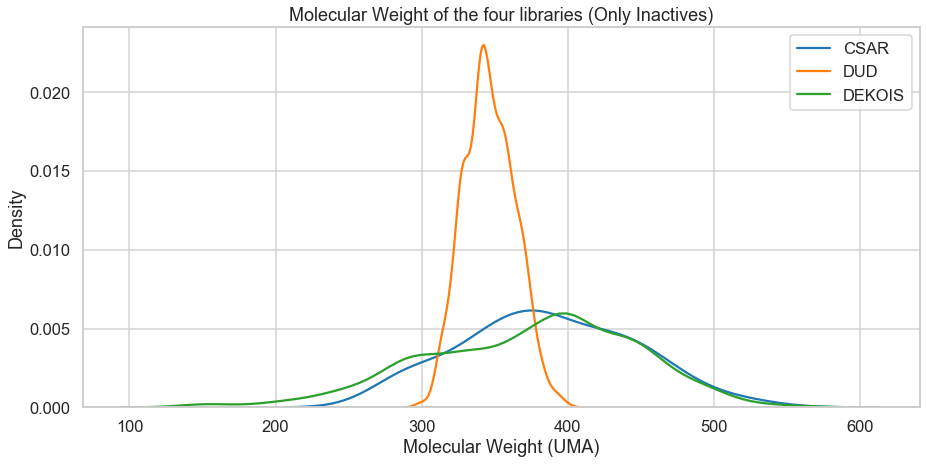

In [20]:
plt.figure(figsize=(15,7))
for name, dataset in lig_datasets.items():
    if name == 'COCRYS':
        continue
    df = dataset[dataset['Activity'] == 'inactive']
    sns.distplot(df['MW'], label = name, hist = False, bins = 30 )
plt.xlabel('Molecular Weight (UMA)')
plt.ylabel('Density')
plt.title('Molecular Weight of the four libraries (Only Inactives)')
plt.grid(c='lightgrey')

## Number of Heavy Atoms

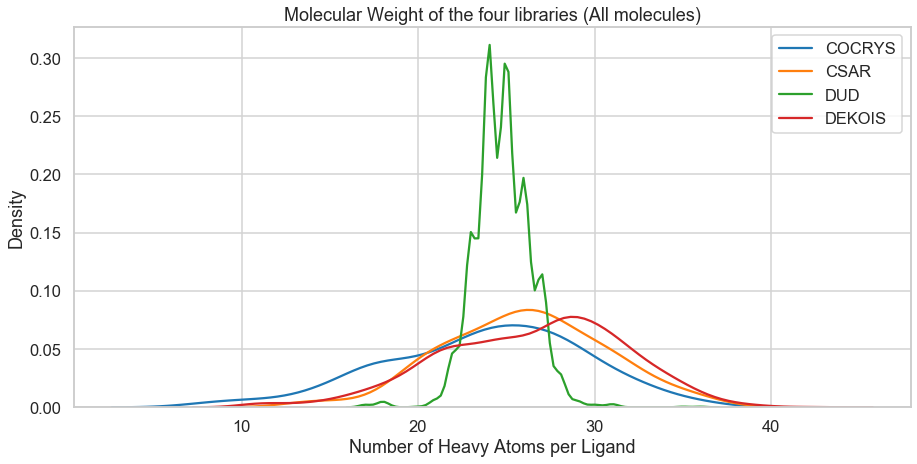

In [21]:
plt.figure(figsize=(15,7))
for name, dataset in lig_datasets.items():
    sns.distplot(dataset['num_atoms'], label = name, hist = False, bins = 30)
plt.xlabel('Number of Heavy Atoms per Ligand')
plt.ylabel('Density')
plt.title('Molecular Weight of the four libraries (All molecules)')
plt.grid(c='lightgrey')

# Compute the Tanimoto similarity

In [22]:
from rdkit.DataStructs import FingerprintSimilarity
from itertools import combinations

In [23]:
matched_ligands = {}

for key_i, key_j in combinations(lig_datasets.keys(), 2):
    print('\n' + '='*20)
    print(key_i, '\t', key_j)
    print('='*20)
    d_i = lig_datasets[key_i]
    d_j = lig_datasets[key_j]
    
    # Create the list
    matched = []
    for k in d_i.index:
        for p in d_j.index:
            fp_sim = FingerprintSimilarity(
                d_i.loc[k, 'fps'], 
                d_j.loc[p, 'fps'])
            
            if fp_sim >= 0.90:
                # Add to the list
                matched.append( {'match_mols': (d_i.loc[k, 'mol_rdk'], 
                                           d_j.loc[p, 'mol_rdk']), 
                                 'match_names': (k, p),
                                 'tanimoto': fp_sim} )
            if fp_sim >= 0.98:
                print(k, '\t', p)
    # add to the dict
    matched_ligands[F'{key_i}-{key_j}'] = matched


COCRYS 	 CSAR
CK2 	 CS12
18K 	 CS18
1CK 	 CS1
03K 	 CS3
09K 	 CS9
11K 	 CS11
20K 	 CS20
42K 	 CS242
60K 	 CS260
61K 	 CS261
62K 	 CS262

COCRYS 	 DUD
CMG 	 ligand_2
NW1 	 ligand_66
NW1 	 ligand_67
1PU 	 ligand_24
MBP 	 ligand_34
MBP 	 ligand_35
UN4 	 ligand_40
UN4 	 ligand_41
2A6 	 ligand_44
2A6 	 ligand_45
6CP 	 ligand_42
6CP 	 ligand_43
4SP 	 ligand_9
LS1 	 ligand_21
LS4 	 ligand_23
ST8 	 ligand_27
UCN 	 ligand_16
OLO 	 ligand_11
RRC 	 ligand_12
D42 	 ligand_64
D42 	 ligand_65
F9Z 	 ligand_69

COCRYS 	 DEKOIS
CMG 	 ligand_37
1PU 	 ligand_27
1CD 	 decoy_37
F9Z 	 ligand_38

CSAR 	 DUD
CS241 	 ligand_71

CSAR 	 DEKOIS

DUD 	 DEKOIS
ligand_2 	 ligand_37
ligand_14 	 ligand_22
ligand_24 	 ligand_27
ligand_69 	 ligand_38
decoy_412 	 decoy_610
decoy_413 	 decoy_610
decoy_414 	 decoy_610
decoy_415 	 decoy_610
decoy_584 	 decoy_281


## Some visualization of the matching molecules

In [24]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
from rdkit.Chem import rdDepictor

In [25]:
matched_ligands.keys()

dict_keys(['COCRYS-CSAR', 'COCRYS-DUD', 'COCRYS-DEKOIS', 'CSAR-DUD', 'CSAR-DEKOIS', 'DUD-DEKOIS'])

In [26]:
def draw_matched_ligs(db, cutoff = 0.99):
    matched_dabatabases = matched_ligands[db]
    mols_to_draw = {}
    for match in matched_dabatabases:
        score = match['tanimoto']
        if score > cutoff:
            # Get both molecules
            mol_i, mol_j = match['match_mols']

            name_i, name_j = match['match_names']
            # Compute 2D coords
            rdDepictor.Compute2DCoords(mol_i)
            rdDepictor.Compute2DCoords(mol_j)

            mols_to_draw[F'{name_i} - {name_j}'] = mol_i
            print('='*25 + ' '*5 + db +  ' '*5 + '='*25)
            img = Chem.Draw.MolsToGridImage(
                (mol_i, mol_j), legends = (name_i, name_j),
                molsPerRow = 2, subImgSize = (300,200))
            display(img)
            mol_i.GetSubstructMatch(mol_j)
            display(mol_i)

### Molecules both in CSAR and DUD

=========================     CSAR-DUD     =========================


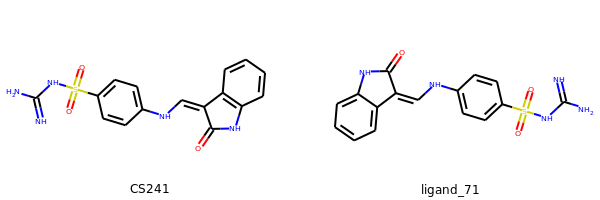

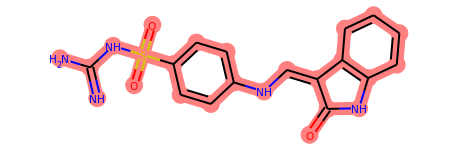

In [27]:
draw_matched_ligs('CSAR-DUD')

### Molecules both in COCRYS and DEKOIS

In [28]:
# draw_matched_ligs('COCRYS-DEKOIS')

### Molecules both in DUD and DEKOIS

In [29]:
# draw_matched_ligs('DUD-DEKOIS')